#Q4

In [2]:
import pickle
import librosa
import numpy as np
from itertools import combinations
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
with open('trs.pkl', 'rb') as f:
    training_data = pickle.load(f)
with open('tes.pkl', 'rb') as f:
    testing_data = pickle.load(f)

In [8]:
def normalize_spectrograms(spectrograms):
    scaler = StandardScaler()
    flattened = spectrograms.reshape(-1, spectrograms.shape[-1])
    normalized_flattened = scaler.fit_transform(flattened)
    return normalized_flattened.reshape(spectrograms.shape)

In [5]:
def stft(signal):
    sig = librosa.stft(signal, n_fft=1024, hop_length=512)
    return np.abs(sig)

In [24]:
X = []
for t in training_data:
    S = stft(t)
    X.append(S)

train_spectra = np.array(X)

Y = []
for z in testing_data:
    Q = stft(z)
    Y.append(Q)

test_spectra = np.array(Y)

In [25]:
 def create_minibatches(spectrograms, n=50, L=45):
    pos_p, neg_p = [], []
    for x in range(n):
        utt = spectrograms[x * 10:(x + 1) * 10]
        if len(utt) < 2:
            continue

        # pos pairs
        if L > len(utt) * (len(utt) - 1) // 2:
            Z = random.choices(list(combinations(utt, 2)), k=L)
        else:
            Z = list(combinations(utt, 2))[:L]
        pos_p.extend(Z)

        # neg pairs
        C = list(set(range(n)) - {x})
        for _ in range(L):
            W = random.choice(utt)
            R = random.choice(C)
            D = spectrograms[R * 10:(R + 1) * 10]
            if D.size > 0:
                T = random.choice(D)
                neg_p.append((W, T))

    return pos_p, neg_p

In [11]:
# padded_train_spectra = np.pad(train_spectra, ((0, 0), (0, 0), (0, 13)), mode='constant')

In [26]:
positive_pairs, negative_pairs = create_minibatches(train_spectra)
X1 = np.array([pair[0] for pair in positive_pairs + negative_pairs])
X2 = np.array([pair[1] for pair in positive_pairs + negative_pairs])
y = np.array([1] * len(positive_pairs) + [0] * len(negative_pairs))


In [27]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [28]:
input_shape = train_spectra[0].shape
embedding_net = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.GRU(64, return_sequences=True, activation='relu'),
    layers.GRU(128, return_sequences=True, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')
])

In [ ]:
input1 = layers.Input(shape=input_shape)
input2 = layers.Input(shape=input_shape)
encoded1 = embedding_net(input1)
encoded2 = embedding_net(input2)

product = layers.Dot(axes=1)([encoded1, encoded2])
hidden = layers.Dense(64, activation='relu')(product)
output = layers.Dense(1, activation='sigmoid')(hidden)
siamese_network = tf.keras.Model(inputs=[input1, input2], outputs=output)

siamese_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history_siamese = siamese_network.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    batch_size=64,
    epochs=20
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 420ms/step - accuracy: 0.5027 - loss: 0.6937 - val_accuracy: 0.5022 - val_loss: 0.6931
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 358ms/step - accuracy: 0.5137 - loss: 0.6931 - val_accuracy: 0.5067 - val_loss: 0.6931
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.5114 - loss: 0.6928 - val_accuracy: 0.4811 - val_loss: 0.6969
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.5203 - loss: 0.6914 - val_accuracy: 0.4822 - val_loss: 0.6974
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 391ms/step - accuracy: 0.5532 - loss: 0.6876 - val_accuracy: 0.4856 - val_loss: 0.6961
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 78s 360ms/step - accuracy: 0.5569 - loss: 0.6850 - val_accuracy: 0.4822 - val_loss: 0.7038
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.5677 - loss: 0.6779 - val_accuracy: 0.4756 - val_loss: 0.6981
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - accuracy: 0.5698 - loss: 0

In [31]:
test_spectra_adjusted = test_spectra[:, :, :32]
print("Adjusted test_spectra shape:", test_spectra_adjusted.shape)

Adjusted test_spectra shape: (200, 513, 32)


In [ ]:
test_pos_pairs, test_neg_pairs = create_minibatches(test_spectra_adjusted)

X1_test = np.array([pair[0] for pair in test_pos_pairs + test_neg_pairs])
X2_test = np.array([pair[1] for pair in test_pos_pairs + test_neg_pairs])
y_test = np.array([1] * len(test_pos_pairs) + [0] * len(test_neg_pairs))

# Evaluate the model
test_loss, test_accuracy = siamese_network.evaluate([X1_test, X2_test], y_test)
print(f"Test Accuracy: {test_accuracy}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8820 - loss: 0.4209
Test Accuracy: 0.6776263117790222


#Got 69-70% in a few runs but couldnt save the file

#Q1

In [ ]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def create_bline_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
bline_model = create_bline_model()


In [ ]:
bline_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bline_model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9800 - val_loss: 0.1335
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9831 - val_loss: 0.1242
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 2.3629e-04 - val_accuracy: 0.9823 - val_loss: 0.1472
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9830 - val_loss: 0.1239
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9840 - val_loss: 0.1237
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9833 - val_loss: 0.1262
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9850 - val_loss: 0.1181
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy

In [ ]:
bline_accuracy = bline_model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Baseline test_acc: {bline_accuracy * 100:.2f}%")

Baseline test_acc: 98.64%


In [ ]:
def get_svd(matrix):
    # eigenvalues and eigenvectors
    eigenvalues, V = np.linalg.eig(np.dot(matrix.T, matrix))
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    V = V[:, sorted_indices]
    singular_values = np.sqrt(eigenvalues)

    U = np.dot(matrix, V) / singular_values
    U = U / np.linalg.norm(U, axis=0)
    Sigma = np.diag(singular_values)
    return U, Sigma, V.T

In [ ]:
def compress_weights(weights, d):
    W, b = weights
    U, S, V = get_svd(W)
    U_reduced = U[:, :d]
    S_reduced = S[:d, :d]
    V_reduced = V[:d, :]
    W_compressed = np.dot(U_reduced, np.dot(S_reduced, V_reduced))
    return [W_compressed, b]

In [ ]:
Dvalues = [10, 20, 50, 100, 200, 784]
test_accuracies = []
for d in Dvalues:
    model = clone_model(bline_model)
    model.set_weights(bline_model.get_weights())
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    for i, layer in enumerate(model.layers):
        if isinstance(layer, Dense):
            weights = bline_model.layers[i].get_weights()
            compressed_weights = compress_weights(weights, d)
            layer.set_weights(compressed_weights)

    compressed_accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
    test_accuracies.append(compressed_accuracy)
    print(f"Test Accuracy for D={d}: {compressed_accuracy * 100:.2f}%")

<ipython-input-67-7dd1135ad6a6>:7: RuntimeWarning: invalid value encountered in sqrt
  singular_values = np.sqrt(eigenvalues)


Test Accuracy for D=10: 69.79%
Test Accuracy for D=20: 87.82%
Test Accuracy for D=50: 98.14%
Test Accuracy for D=100: 98.50%
Test Accuracy for D=200: 98.61%
Test Accuracy for D=784: 98.63%


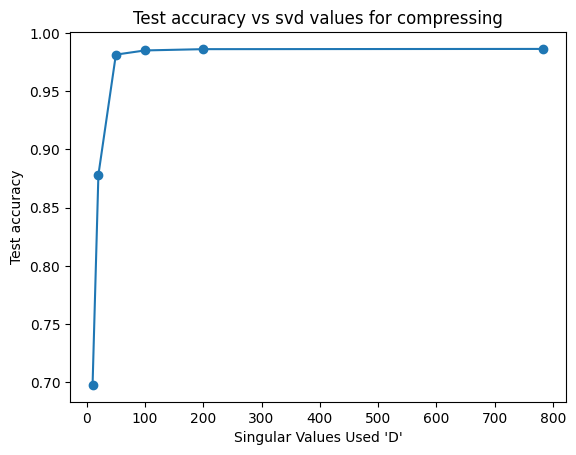

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Dvalues, test_accuracies, marker='o')
plt.xlabel("Singular Values Used 'D'")
plt.ylabel("Test accuracy")
plt.title("Test accuracy vs svd values for compressing")
plt.show()

#Q2

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras.models import Model
from scipy.linalg import svd
import tensorflow as tf

def get_svd_weights(base_model, d=20):

    svd_weights = []
    for layer in base_model.layers:
        if isinstance(layer, Dense):
            # weights and compute SVD
            weights = layer.get_weights()[0]
            U, S, V = svd(weights)

            # dimensions reduce
            U = U[:, :d]
            S = S[:d]
            V = V[:d, :]
            svd_weights.append((U, S, V))

    return svd_weights

def build_factorized_model(input_shape=(28, 28), hidden_units=1024, num_layers=4):

    inp = Input(shape=input_shape)
    x = Flatten()(inp)

    # hidden
    for _ in range(num_layers):
        # U layer
        x = Dense(hidden_units,use_bias=False,kernel_initializer='glorot_uniform')(x)
        # V layer
        x = Dense(hidden_units,use_bias=True,kernel_initializer='glorot_uniform')(x)
        x = Activation('relu')(x)
    out = Dense(10, activation='softmax')(x)

    return Model(inp, out)

def train_model(x_train, y_train, x_test, y_test):

    svd_weights = get_svd_weights(bline_model) # get weights
    model = build_factorized_model()
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test))

    return model, history

# Run training
factor_model, history_factor = train_model(x_train, y_train, x_test, y_test)

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8817 - loss: 0.3971 - val_accuracy: 0.9597 - val_loss: 0.1370
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9730 - loss: 0.0871 - val_accuracy: 0.9742 - val_loss: 0.0815
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9805 - loss: 0.0608 - val_accuracy: 0.9763 - val_loss: 0.0855
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9865 - loss: 0.0445 - val_accuracy: 0.9776 - val_loss: 0.0823
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9888 - loss: 0.0361 - val_accuracy: 0.9780 - val_loss: 0.0819
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9902 - loss: 0.0319 - val_accuracy: 0.9746 - val_loss: 0.0893
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9915 - loss: 0.0294 - val_accuracy: 0.9828 - val_loss: 0.0623
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9936 - loss: 0.0217 - val_accuracy: 0.

In [ ]:
test_accuracy = factor_model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Accuracy for test set after fine-tuning with d=20: {test_accuracy * 100:.2f}%")

Accuracy for test set after fine-tuning with d=20: 98.28%


#Q3

In [ ]:
class CompressedNN(tf.keras.Model):
    def __init__(self, base_weights, d=20):
        super().__init__()
        self.rank = d
        self.flatten = Flatten()
        self.hidden = []
        self.compressed_weights = []

        # hidden layers -- compressed weights
        for weights in base_weights[:-1]:
            layer = Dense(1024, activation='relu')
            layer.build((None, weights[0].shape[0]))
            compressed = compress_weights(weights, d)
            layer.set_weights(compressed)

            self.hidden.append(layer)
            self.compressed_weights.append(compressed)

        self.out = Dense(10, activation='softmax')
        self.out.build((None, base_weights[-1][0].shape[0]))
        self.out.set_weights(base_weights[-1])

    def call(self, x):
        x = self.flatten(x)
        for layer in self.hidden:
            x = layer(x)
        return self.out(x)


In [ ]:
def train_compressed_model(x_train, y_train, x_test, y_test, base_model, d=20):
    # Extract base model weights
    base_weights = [layer.get_weights() for layer in base_model.layers if isinstance(layer, Dense)]

    # Initialize compressed model
    model = CompressedNN(base_weights, d)

    # Compile and train
    model.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test))
    return model

compressed_model = train_compressed_model(x_train, y_train, x_test, y_test, bline_model, d=20)

<ipython-input-67-7dd1135ad6a6>:7: RuntimeWarning: invalid value encountered in sqrt
  singular_values = np.sqrt(eigenvalues)


Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9692 - loss: 0.1437 - val_accuracy: 0.9792 - val_loss: 0.0822
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9881 - loss: 0.0365 - val_accuracy: 0.9795 - val_loss: 0.0812
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9924 - loss: 0.0219 - val_accuracy: 0.9807 - val_loss: 0.0814
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9941 - loss: 0.0190 - val_accuracy: 0.9826 - val_loss: 0.0775
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9792 - val_loss: 0.0931
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9813 - val_loss: 0.0874
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.9806 - val_loss: 0.1108
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 0.

In [ ]:
test_acc = compressed_model.evaluate(x_test, y_test)[1]
print(f"Compressed model accuracy: {test_acc:.1%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9770 - loss: 0.1655
Compressed model accuracy: 98.1%
